## Rat 05 inverse problem with linear elasticity

Interpolating ic...
Interpolating tumor...
Plotting initial condition and target...


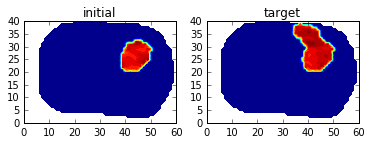

Optimizing...
Solved reaction diffusion for time = 0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solved reaction diffusion for time = 0.0
Plotting initial condition and target...


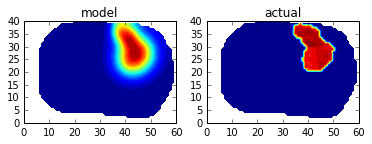

norm(k_opt) = 15.0437266307
J_opt = 188.203414484


TypeError: objective() takes exactly 5 arguments (4 given)

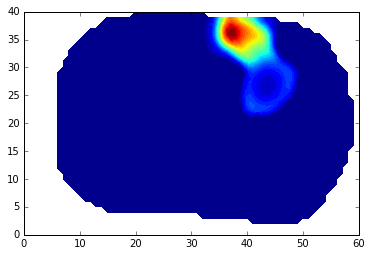

In [2]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from fenics_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(INFO) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    """
        Function to accept matlab .mat file with tumor data and interpolate values onto mesh
    """
    print("Interpolating "+mat_name+"...")
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/theta  # Needs to be adjusted to fit the mesh correctly
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    print("Plotting initial condition and target...")
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p, record=True, annotate=False):
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    global D
    
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        return 2*mu*E(u)+lmbda*tr(E(u))*Identity(2)
    def vonmises(u):
        s         = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V, annotate=annotate)
    def sigma_form(u,phi):
        return 2*mu*(E(u)-beta*phi*Identity(2))+lmbda*(tr(E(u))-2*beta*phi)*Identity(2)
    
    U           = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc          = DirichletBC(U, Constant((0.,0.)), boundary)
    p_n         = interpolate(initial_p,V)
    u           = TrialFunction(U)
    v           = TestFunction(U)
    F_LE        = inner(sigma_form(u, p_n), E(v))*dx 
    a, L        = lhs(F_LE), rhs(F_LE)
    u           = Function(U, annotate=annotate)
    parameters["form_compiler"]["quadrature_degree"] = 2
    parameters["form_compiler"]["cpp_optimize"] = True
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
    def le():
        solve(a == L, u, bc, 
              form_compiler_parameters=ffc_options,
              annotate=annotate)
        return u

    # First iteration solving for displacement, and using the von mises stress field for D
    disp        = le()
    vm          = vonmises(disp)
    D           = project(D0*exp(-gammaD*vm),V, annotate=annotate)

    # Set up reaction-diffusion problem
    dp          = TrialFunction(V)
    p           = Function(V, annotate=annotate)
    q           = TestFunction(V)
    F_RD        = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD        = derivative(F_RD,p,dp)
    
    # Prepare the solution
    t = 0.
        
    for n in range(num_steps):
        if (n%rtime == 0):
            if record:        # save the current solution, k field, displacement, and diffusion
                # Rename parameters for saving
                u.rename('u','displacement')
                p_n.rename('phi_T','tumor fraction')
                vm.rename("vm","Von Mises")
                D.rename("D","diffusion coefficient")
                k.rename('k','k field')  
                file_results.write(p_n,t)
                file_results.write(u,t)
                file_results.write(k,t)
                file_results.write(vm,t)
                file_results.write(D,t)
        # Update current time
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        prm = solver_RD.parameters
        prm['newton_solver']['absolute_tolerance'] = 1E-7
        prm['newton_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['maximum_iterations'] = 51
        prm['newton_solver']['relaxation_parameter'] = 1.0
        prm['newton_solver']['linear_solver'] = 'gmres'
        prm['newton_solver']['preconditioner'] = 'ilu'
        prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
        prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
        solver_RD.solve(annotate=annotate)

        # Update previous solution
        p_n.assign(p, annotate=annotate)
        disp = le()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)

    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2, r_coeff3):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + \
        r_coeff2*assemble(dot(grad(k),grad(k))*dx) + \
        r_coeff3*assemble(sqrt(dot(grad(p),grad(p))+eps)*dx)
        # assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    print("Optimizing...")
    
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p, False, True)

    J = objective(p, target_p, r_coeff1, r_coeff2, r_coeff3)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)
    
    # upper and lower bound for the parameter field
    k_lb, k_ub = Function(V, annotate=False), Function(V, annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 8.
    D_lb = 0.0
    D_ub = 10.0
    bnds = [[k_lb,D_lb],[k_ub,D_ub]]

    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds=bnds, tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
#global t1,case,r_coeff1, r_coeff2, input_dir, output_dir, file_results, mesh, V, T, num_steps,\
#    dt, theta, mu, nu, lmbda, beta, gammaD, D0, k0, k, initial_p, target_p
t1         = time()
r_coeff1   = 0.01
r_coeff2 = 0.001
r_coeff3 = 1.
eps = .01
input_dir  = "../../rat-data/rat05/"
output_dir = './output/rat05'

print('Output saved to '+output_dir)
print('Regularization coefficient (k*k) = '+str(r_coeff1))
print('Regularization coefficient (grad(k)*grad(k)) = '+str(r_coeff2))
print('Regularization coefficient (grad(p)*grad(p)) = '+str(r_coeff3))

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'le.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
rtime = 20 # How often to record results

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T             = 2.               # final time 
num_steps     = 20              # number of time steps
dt            = T/num_steps      # time step size
theta         = 50970.           # carrying capacity - normalize cell data by this 
mu            = .42              # kPa, bulk shear modulus
nu            = .45
lmbda         = 2*mu*nu/(1-2*nu)
beta          = 1.
gammaD        = .1     # initial guess of gamma_D

# Load initial tumor condition data
initial_p = interp(input_dir+"ic.mat","ic")
initial_p.rename('initial','tumor at day 0')
target_p  = interp(input_dir+"tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Initial guesses
D0     = Constant(1.)     # mobility or diffusion coefficient
k0     = Constant(2.)    # growth rate initial guess
k      = project(k0,V, annotate=False)

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True,False) # run the forward model using the optimized k field
vis_obs(model_p,target_p,'model','actual')
plot(k)

print('norm(k_opt) = '+str(norm(k)))
print('D0 = '+str(D0.values()[0]))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2, r_coeff3)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.,0.)))

print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')


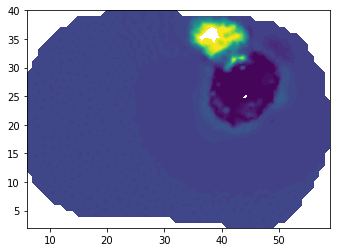

In [10]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import h5py

mesh = Mesh('../../rat-data/rat05/gmsh.xml')
V = FunctionSpace(mesh, "CG", 1)
k0  = Function(V)

# Open the result file for reading
fl = h5py.File("../output/rat05le/notime.h5", "r")

# Choose the first time step
vec = fl["/VisualisationVector/1"]

# Scalar FunctionSpace Q is required for mapping vertices to dofs 
Q = FunctionSpace(mesh, 'CG', 1)
v2d = vertex_to_dof_map(Q)

# Now map vertexfunction to the V function space
k0.vector()[v2d] = vec[:]
plot(k0)

In [1]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from fenics_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(INFO) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    """
        Function to accept matlab .mat file with tumor data and interpolate values onto mesh
    """
    print("Interpolating "+mat_name+"...")
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/theta  # Needs to be adjusted to fit the mesh correctly
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    print("Plotting initial condition and target...")
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p, record=True, annotate=False):
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    global D
    
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        return 2*mu*E(u)+lmbda*tr(E(u))*Identity(2)
    def vonmises(u):
        s         = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V, annotate=annotate)
    def sigma_form(u,phi):
        return 2*mu*(E(u)-beta*phi*Identity(2))+lmbda*(tr(E(u))-2*beta*phi)*Identity(2)
    
    U           = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc          = DirichletBC(U, Constant((0.,0.)), boundary)
    p_n         = interpolate(initial_p,V)
    u           = TrialFunction(U)
    v           = TestFunction(U)
    F_LE        = inner(sigma_form(u, p_n), E(v))*dx 
    a, L        = lhs(F_LE), rhs(F_LE)
    u           = Function(U, annotate=annotate)
    parameters["form_compiler"]["quadrature_degree"] = 2
    parameters["form_compiler"]["cpp_optimize"] = True
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    ffc_options = {"quadrature_degree": 2, "cpp_optimize": True}
    def le():
        solve(a == L, u, bc, 
              form_compiler_parameters=ffc_options,
              annotate=annotate)
        return u

    # First iteration solving for displacement, and using the von mises stress field for D
    disp        = le()
    vm          = vonmises(disp)
    D           = project(D0*exp(-gammaD*vm),V, annotate=annotate)

    # Set up reaction-diffusion problem
    dp          = TrialFunction(V)
    p           = Function(V, annotate=annotate)
    q           = TestFunction(V)
    F_RD        = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD        = derivative(F_RD,p,dp)
    
    # Prepare the solution
    t = 0.
        
    for n in range(num_steps):
        if (n%rtime == 0):
            if record:        # save the current solution, k field, displacement, and diffusion
                # Rename parameters for saving
                u.rename('u','displacement')
                p_n.rename('phi_T','tumor fraction')
                vm.rename("vm","Von Mises")
                D.rename("D","diffusion coefficient")
                k.rename('k','k field')  
                file_results.write(p_n,t)
                file_results.write(u,t)
                file_results.write(k,t)
                file_results.write(vm,t)
                file_results.write(D,t)
        # Update current time
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p, J=J_RD,form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        prm = solver_RD.parameters
        prm['newton_solver']['absolute_tolerance'] = 1E-7
        prm['newton_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['maximum_iterations'] = 51
        prm['newton_solver']['relaxation_parameter'] = 1.0
        prm['newton_solver']['linear_solver'] = 'gmres'
        prm['newton_solver']['preconditioner'] = 'ilu'
        prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-8
        prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-6
        prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
        solver_RD.solve(annotate=annotate)

        # Update previous solution
        p_n.assign(p, annotate=annotate)
        disp = le()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V, annotate=annotate)

    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2, r_coeff3):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + \
        r_coeff2*assemble(dot(grad(k),grad(k))*dx) + \
        r_coeff3*assemble(sqrt(dot(grad(p),grad(p))+eps)*dx)
        # assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    print("Optimizing...")
    
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p, False, True)

    J = objective(p, target_p, r_coeff1, r_coeff2, r_coeff3)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)
    
    # upper and lower bound for the parameter field
    k_lb, k_ub = Function(V, annotate=False), Function(V, annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 8.
    D_lb = 0.0
    D_ub = 10.0
    bnds = [[k_lb,D_lb],[k_ub,D_ub]]

    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds=bnds, tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
#global t1,case,r_coeff1, r_coeff2, input_dir, output_dir, file_results, mesh, V, T, num_steps,\
#    dt, theta, mu, nu, lmbda, beta, gammaD, D0, k0, k, initial_p, target_p
t1         = time()
r_coeff1   = 0.01
r_coeff2 = 0.001
r_coeff3 = 1.
eps = .01
input_dir  = "../../rat-data/rat05/"
output_dir = './output/rat05'

print('Output saved to '+output_dir)
print('Regularization coefficient (k*k) = '+str(r_coeff1))
print('Regularization coefficient (grad(k)*grad(k)) = '+str(r_coeff2))
print('Regularization coefficient (grad(p)*grad(p)) = '+str(r_coeff3))

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'le.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
rtime = 20 # How often to record results

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T             = 2.               # final time 
num_steps     = 20              # number of time steps
dt            = T/num_steps      # time step size
theta         = 50970.           # carrying capacity - normalize cell data by this 
mu            = .42              # kPa, bulk shear modulus
nu            = .45
lmbda         = 2*mu*nu/(1-2*nu)
beta          = 1.
gammaD        = .1     # initial guess of gamma_D

# Load initial tumor condition data
initial_p = interp(input_dir+"ic.mat","ic")
initial_p.rename('initial','tumor at day 0')
target_p  = interp(input_dir+"tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Initial guesses
D0     = Constant(1.)     # mobility or diffusion coefficient
k0     = Constant(2.)    # growth rate initial guess
k      = project(k0,V, annotate=False)

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True,False) # run the forward model using the optimized k field
vis_obs(model_p,target_p,'model','actual')
plot(k)

print('norm(k_opt) = '+str(norm(k)))
print('D0 = '+str(D0.values()[0]))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2, r_coeff3)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.,0.)))

print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')


Output saved to ./output/rat05
Regularization coefficient (k*k) = 0.01
Regularization coefficient (grad(k)*grad(k)) = 0.001
Regularization coefficient (grad(p)*grad(p)) = 1.0
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to perform just-in-time compilation of form.
*** Reason:  ffc.jit failed with message:
Traceback (most recent call last):
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/dolfin/compilemodules/jit.py", line 142, in jit
    result = ffc.jit(ufl_object, parameters=p)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 218, in jit
    module = jit_build(ufl_object, module_name, parameters)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 134, in jit_build
    generate=jit_generate)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/dijitso/jit.py", line 167, in jit
    header, source, dependencies = generate(jitable, name, signature, params["generator"])
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 67, in jit_generate
    prefix=module_name, parameters=parameters, jit=True)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/compiler.py", line 150, in compile_element
    prefix, parameters, jit)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/compiler.py", line 190, in compile_ufl_objects
    ir = compute_ir(analysis, prefix, parameters, jit)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/representation.py", line 171, in compute_ir
    for e in elements]
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/representation.py", line 203, in _compute_element_ir
    fiat_element = create_element(ufl_element)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/fiatinterface.py", line 99, in create_element
    element = _create_fiat_element(ufl_element)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/fiatinterface.py", line 196, in _create_fiat_element
    element = ElementClass(fiat_cell, degree)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/FIAT/lagrange.py", line 56, in __init__
    poly_set = polynomial_set.ONPolynomialSet(ref_el, degree)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/FIAT/polynomial_set.py", line 176, in __init__
    dv = expansion_set.tabulate_derivatives(degree, pts)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/FIAT/expansions.py", line 262, in tabulate_derivatives
    data = _tabulate_dpts(self._tabulate, 2, n, order, numpy.array(pts))
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/FIAT/expansions.py", line 104, in _tabulate_dpts
    phi.append(form_derivative(phi[-1]))
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/FIAT/expansions.py", line 50, in form_derivative
    out = [sympy.diff(F, X[j]) for j in range(D)]
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/sympy/core/function.py", line 1993, in diff
    return Derivative(f, *symbols, **kwargs)
  File "/home/xoab/anaconda2/envs/fenics/lib/python2.7/site-packages/sympy/core/function.py", line 1117, in __new__
    it cannot be differentiated.'''  6.952932e-310xpr))
ValueError: 
Since there are no variables in the expression [0, 0], it cannot be
differentiated.
.
*** Where:   This error was encountered inside jit.py.
*** Process: 0
*** 
*** DOLFIN version: 2017.2.0
*** Git changeset:  774aa9b05f5a21fcf3d1bd632e722933a05fdb45
*** -------------------------------------------------------------------------


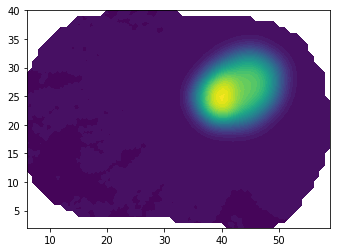

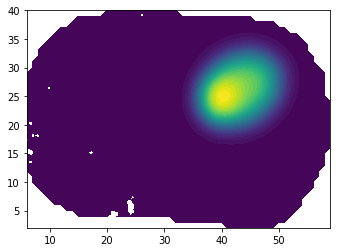

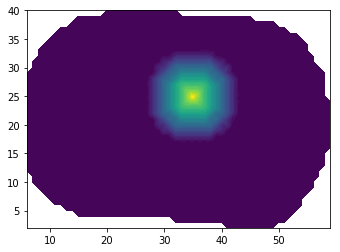

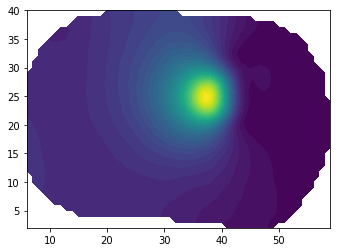

In [24]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import h5py

mesh = Mesh('../rat-data/rat05/gmsh.xml')
V = FunctionSpace(mesh, "CG", 1)
k0  = Function(V)

# Open the result file for reading
fl = h5py.File("./output/le_verify_params6.h5", "r")

for i in [0,1,2,3]:
    # Choose the first time step
    vec = fl["/VisualisationVector/"+str(i)]

    # Scalar FunctionSpace Q is required for mapping vertices to dofs 
    Q = FunctionSpace(mesh, 'CG', 1)
    v2d = vertex_to_dof_map(Q)

    # Now map vertexfunction to the V function space
    plt.figure()
    k0.vector()[v2d] = vec[:]
    plot(k0)